## Example of usage of the DataLoader

In [1]:
from cellgroup.data import InMemoryDataset
from cellgroup.configs import DataConfig
from cellgroup.data.datasets.harvard import SampleHarvard, ChannelHarvard, get_fnames
from cellgroup.data.utils import in_memory_collate_fn

#### 1. Sequential patching

In [ ]:
dset_config = DataConfig(
    samples=[SampleHarvard.A06],
    channels=[ChannelHarvard.Ch1, ChannelHarvard.Ch13],
    time_steps=(32, 42, 2),
    img_dim="2D",
    patch_size=(256, 256),
    patch_overlap=None,
)

In [ ]:
dset = InMemoryDataset(
    data_dir="/group/jug/federico/data/Cellgroup",
    data_config=dset_config,
    get_fnames_fn=get_fnames,
)

In [ ]:
dset.data.shape

In [ ]:
dset.patches.shape

In [ ]:
len(dset)

In [ ]:
patch, coords = dset[1123]

In [ ]:
print(patch.shape)
print(coords)

In [ ]:
import matplotlib.pyplot as plt

_, axes = plt.subplots(10, 10, figsize=(30, 30))
for i, ax in enumerate(axes.flat):
    patch, _ = dset[i]
    ax.imshow(patch, cmap="viridis")
    ax.axis("off")

#### 2. Overlapped patching

In [2]:
dset_config = DataConfig(
    samples=[SampleHarvard.A06],
    channels=[ChannelHarvard.Ch1, ChannelHarvard.Ch13],
    time_steps=(32, 42, 2),
    img_dim="2D",
    patch_size=(256, 256),
    patch_overlap=(128, 128),
    batch_size=32,
    dloader_kwargs={
        "num_workers": 0,
        "collate_fn": in_memory_collate_fn,
    },
)

In [3]:
dset = InMemoryDataset(
    data_dir="/group/jug/federico/data/Cellgroup",
    data_config=dset_config,
    get_fnames_fn=get_fnames,
)

In [4]:
dset.data.shape

(1, 2, 5, 6456, 6380)

In [5]:
dset.patches.shape

(1, 2, 5, 2450, 256, 256)

In [6]:
patch, coords = dset[333]

In [7]:
print(patch.shape)
print(coords)

(256, 256)
{<Axis.N>: array(<Sample.A06>, dtype=object), <Axis.C>: array(<Channel.Ch1>, dtype=object), <Axis.T>: 0, <Axis.P>: array(PatchInfo(array_shape=(6456, 6380), last_patch=False, overlap_crop_coords=((64, 192), (64, 192)), stitch_coords=((832, 960), (5056, 5184))),
      dtype=object)}


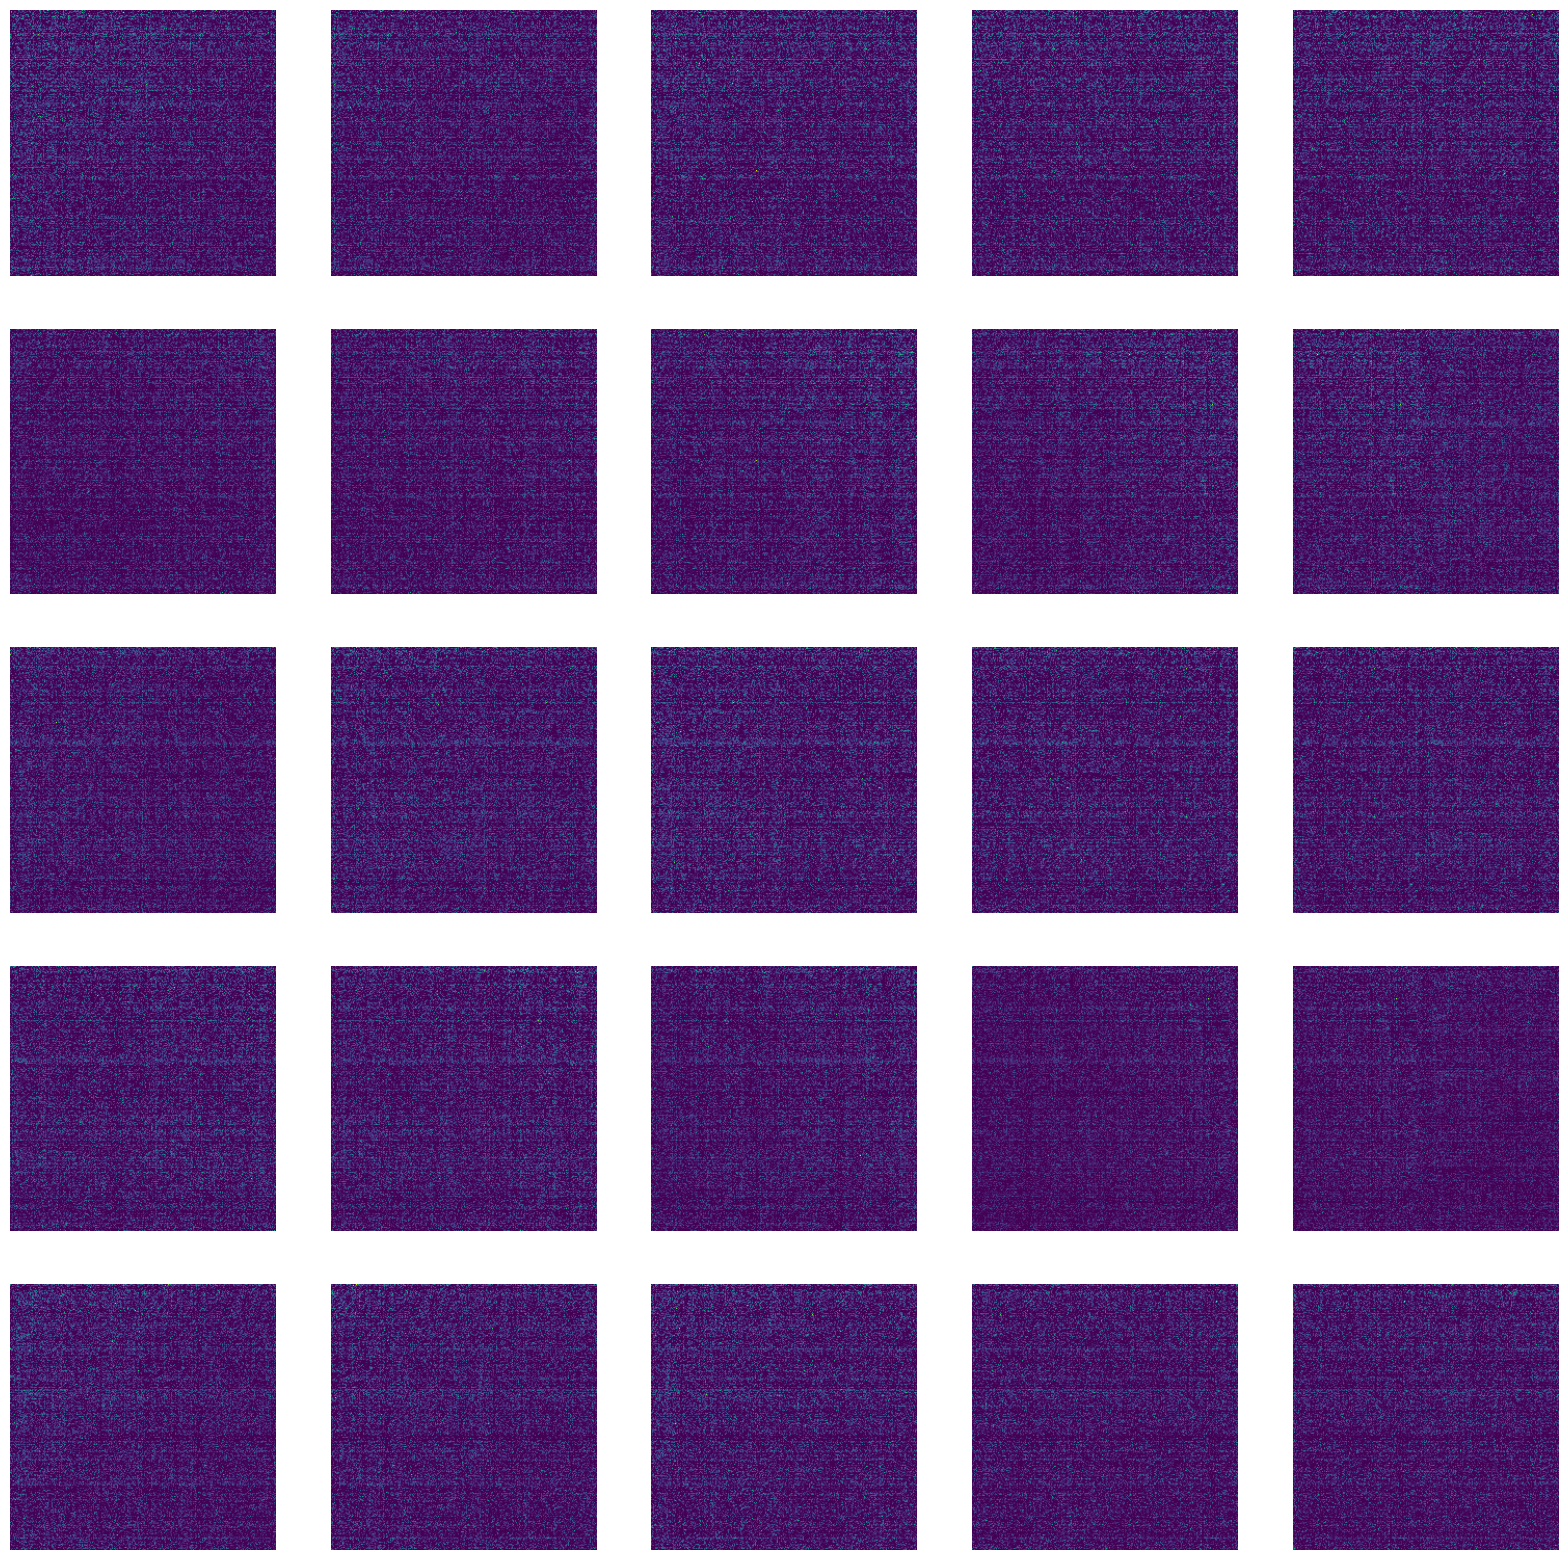

In [8]:
import matplotlib.pyplot as plt

_, axes = plt.subplots(5, 5, figsize=(20, 20))
for i, ax in enumerate(axes.flat):
    patch, _ = dset[i]
    ax.imshow(patch, cmap="viridis")
    ax.axis("off")

#### 3. Stitch Overlapped patches

Simulate model output using a dataloader

In [9]:
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader

from cellgroup.utils import Axis

In [10]:
dloader = DataLoader(
    dset, 
    batch_size=dset_config.batch_size, 
    shuffle=False, 
    num_workers=dset_config.dloader_kwargs.get("num_workers"), 
    collate_fn=dset_config.dloader_kwargs.get("collate_fn")
)

In [11]:
patches = []
coords = []
for batch in tqdm(dloader):
    patches.append(batch[0])
    coords.extend(batch[1])
patches = np.concatenate(patches, axis=0)

100%|██████████| 766/766 [00:24<00:00, 31.69it/s]


In [12]:
patches.shape, len(coords)

((24500, 256, 256), 24500)

In [14]:
coords[0][Axis.P].item().last_patch

False

In [15]:
for i, coord in enumerate(coords):
    if coord[Axis.P].item().last_patch:
        print(f"Found last tile at index {i}!")

Found last tile at index 2449!
Found last tile at index 4899!
Found last tile at index 7349!
Found last tile at index 9799!
Found last tile at index 12249!
Found last tile at index 14699!
Found last tile at index 17149!
Found last tile at index 19599!
Found last tile at index 22049!
Found last tile at index 24499!


In [16]:
from cellgroup.data.patching import stitch_patches_single

In [27]:
patch_infos = [
    coords[i][Axis.P].item() for i in range(len(coords))
]

start, end = 0, 0
imgs = []
for i in tqdm(range(len(patch_infos)), desc="Stitching patches"):
    if patch_infos[i].last_patch:
        end = i + 1
        img = stitch_patches_single(patches[start:end], patch_infos[start:end])
        # append coords to get xr.DataArray
        imgs.append(img)
        start = end        

Stitching patches: 100%|██████████| 24500/24500 [00:00<00:00, 31859.11it/s]


In [29]:
len(imgs), imgs[0].shape

(10, (6456, 6380))